In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from data_models.basic import Tabular, LOCOData, LinearData, MultiClass
from models.basic import SVM, LogisticReg, RandForestRegressor
from conformal_prediction.basic import SimpleConformal
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import matplotlib.patches as mpatches
from collections import defaultdict
import json


In [10]:
multi_data = MultiClass(n=10000, n_features=10, n_informative=8, n_classes=10)
multi_data.X_y_split(y='y')

In [10]:
plot = None
B = 1000
model = RandomForestClassifier()
conformal_type = 'adaptive'
alpha = 0.05

boot_cov = []
boot_size = []
boot_cov_1 = defaultdict(list)
boot_size_1 = defaultdict(list)
boot_cov_2 = defaultdict(list)
boot_size_2 = defaultdict(list)

for i in range(B):

    if i % 50 == 0:
        print(i)

    multi_data = MultiClass(n=10000, n_features=10, n_informative=8, n_classes=10)
    multi_data.X_y_split(y='y')

    model_all = model
    model_all.fit(multi_data.train_data_X, multi_data.train_data_y)
    model_all = copy.copy(model_all)

    simple_conformal = SimpleConformal(alpha=alpha, type=conformal_type)
    lambda_all = simple_conformal.calibrate(data_X=multi_data.calib_data_X, data_y=multi_data.calib_data_y, model=model_all)
    pred_all = simple_conformal.predict(data=multi_data.test_data_X, model=model_all, lambda_conformal=lambda_all)
    cov_all, size_all = simple_conformal.evaluate(pred=pred_all, true_data=multi_data.test_data_y, plot=False)

    boot_cov.append(cov_all)
    boot_size.append(size_all)

    data_X_train = copy.copy(multi_data.train_data_X)
    data_X_calib = copy.copy(multi_data.calib_data_X)
    data_X_test = copy.copy(multi_data.test_data_X)
    
    for variable in multi_data.calib_data_X.columns:

        # Train Twice
        
        data_X_train_j_2 = data_X_train.loc[:, data_X_train.columns!=variable]
        data_X_calib_j_2 = data_X_calib.loc[:, data_X_calib.columns!=variable]
        data_X_test_j_2 = data_X_test.loc[:, data_X_test.columns!=variable]

        model_j = model
        model_j.fit(data_X_train_j_2, multi_data.train_data_y)

        lambda_j_2 = simple_conformal.calibrate(data_X=data_X_calib_j_2, data_y=multi_data.calib_data_y, model=model_j)
        pred_j_2 = simple_conformal.predict(data=data_X_test_j_2, model=model_j, lambda_conformal=lambda_j_2)
        cov_j_2, size_j_2 = simple_conformal.evaluate(pred=pred_j_2, true_data=multi_data.test_data_y, plot=False)
        
        boot_cov_2[variable].extend([cov_j_2])
        boot_size_2[variable].extend([size_j_2])

        # Train Once
        data_X_calib_j_1 = copy.copy(multi_data.calib_data_X)
        data_X_calib_j_1[variable] = 0
        data_X_test_j_1 = copy.copy(multi_data.test_data_X)
        data_X_test_j_1[variable] = 0   

        lambda_j_1 = simple_conformal.calibrate(data_X=data_X_calib_j_1, data_y=multi_data.calib_data_y, model=model_all)
        pred_j_1 = simple_conformal.predict(data=data_X_test_j_1, model=model_all, lambda_conformal=lambda_j_1)
        cov_j_1, size_j_1 = simple_conformal.evaluate(pred=pred_j_1, true_data=multi_data.test_data_y, plot=False)

        boot_cov_1[variable].extend([cov_j_1])
        boot_size_1[variable].extend([size_j_1])

with open('data_results/Classification/rf_adaptive_coverage_full.json', 'w') as fp:
    json.dump(boot_cov, fp)

with open('data_results/Classification/rf_adaptive_size_full.json', 'w') as fp:
    json.dump(boot_size, fp)

with open('data_results/Classification/rf_adaptive_train_once_coverage.json', 'w') as fp:
    json.dump(boot_cov_1, fp)

with open('data_results/Classification/rf_adaptive_train_once_size.json', 'w') as fp:
    json.dump(boot_size_1, fp)

with open('data_results/Classification/rf_adaptive_train_twice_coverage.json', 'w') as fp:
    json.dump(boot_cov_2, fp)

with open('data_results/Classification/rf_adaptive_train_twice_size.json', 'w') as fp:
    json.dump(boot_size_2, fp)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [23]:
with open('data_results/Classification/lr_adaptive_coverage_full.json', 'w') as fp:
    json.dump(boot_cov, fp)

with open('data_results/Classification/lr_adaptive_size_full.json', 'w') as fp:
    json.dump(boot_size, fp)

with open('data_results/Classification/lr_adaptive_train_once_coverage.json', 'w') as fp:
    json.dump(boot_cov_1, fp)

with open('data_results/Classification/lr_adaptive_train_once_size.json', 'w') as fp:
    json.dump(boot_size_1, fp)

with open('data_results/Classification/lr_adaptive_train_twice_coverage.json', 'w') as fp:
    json.dump(boot_cov_2, fp)

with open('data_results/Classification/lr_adaptive_train_twice_size.json', 'w') as fp:
    json.dump(boot_size_2, fp)

In [24]:
print('Size Full', np.mean(boot_size))
print('Coverage Full', np.mean(boot_cov))

print('F1 CP-1 Size', np.mean(boot_size_1['f1']))
print('F3 CP-1 Size', np.mean(boot_size_1['f3']))
print('F9 CP-1 Size', np.mean(boot_size_1['f9']))

print('F1 CP-2 Size', np.mean(boot_size_2['f1']))
print('F3 CP-2 Size', np.mean(boot_size_2['f3']))
print('F9 CP-2 Size', np.mean(boot_size_2['f9']))

print('F1 CP-1 Coverage', np.mean(boot_cov_1['f1']))
print('F3 CP-1 Coverage', np.mean(boot_cov_1['f3']))
print('F9 CP-1 Coverage', np.mean(boot_cov_1['f9']))

print('F1 CP-2 Coverage', np.mean(boot_cov_2['f1']))
print('F3 CP-2 Coverage', np.mean(boot_cov_2['f3']))
print('F9 CP-2 Coverage', np.mean(boot_cov_2['f9']))

Size Full 6.826241
Coverage Full 0.9494750000000001
F1 CP-1 Size 7.074872
F3 CP-1 Size 7.088652
F9 CP-1 Size 6.825209000000001
F1 CP-2 Size 7.0579670000000005
F3 CP-2 Size 7.068564
F9 CP-2 Size 6.8252120000000005
F1 CP-1 Coverage 0.9491609999999999
F3 CP-1 Coverage 0.949519
F9 CP-1 Coverage 0.9495909999999999
F1 CP-2 Coverage 0.949221
F3 CP-2 Coverage 0.949433
F9 CP-2 Coverage 0.949582


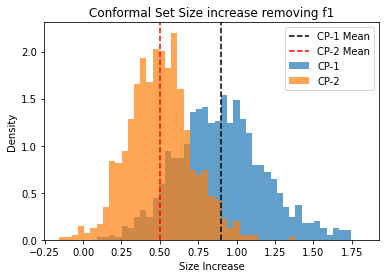

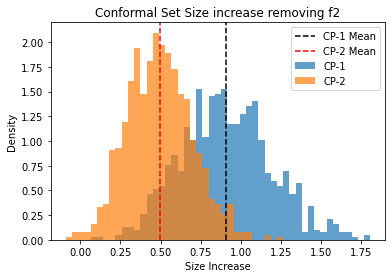

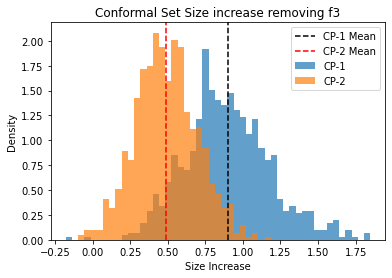

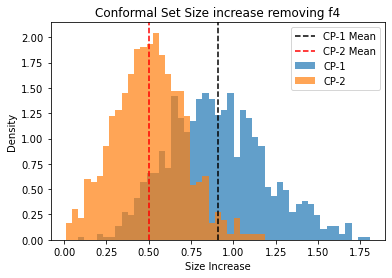

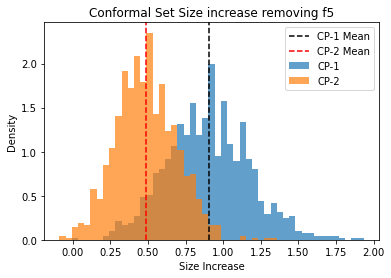

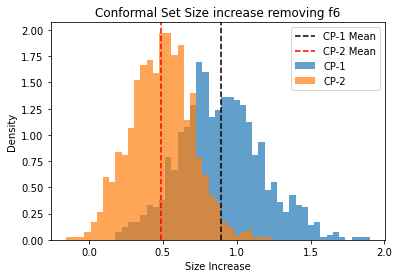

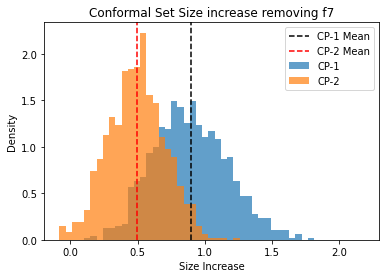

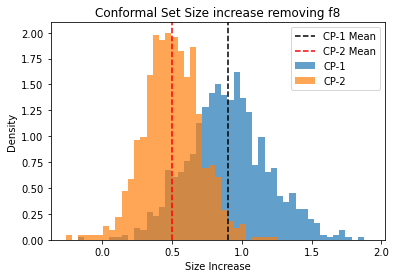

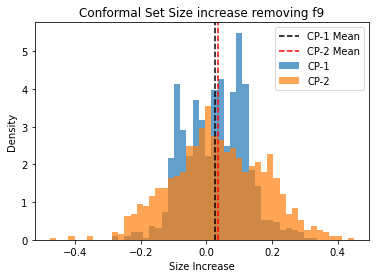

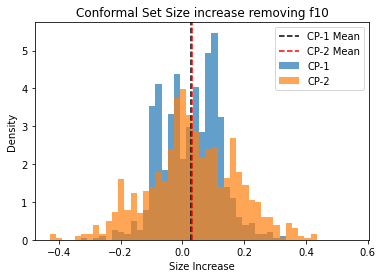

In [11]:
for i, variable in enumerate(multi_data.calib_data_X.columns):

    data_1 = np.array(boot_size_1[variable]) - np.array(boot_size)
    data_2 = np.array(boot_size_2[variable]) - np.array(boot_size)

    # fixed bin size
    bins = np.arange(min(min(data_1), min(data_2)), max(max(data_1), max(data_2)), (max(max(data_1), 
                     max(data_2))-min(min(data_1), min(data_2)))/50) # fixed bin size

    # plt.xlim([min(0, min(data))-5, max(data)+5])

    plt.hist(data_1, bins=bins, alpha=0.7, density=True, label='CP-1')
    plt.hist(data_2, bins=bins, alpha=0.7, density=True, label='CP-2')
    plt.axvline(x=np.mean(data_1), color='black', linestyle='--', label='CP-1 Mean')
    plt.axvline(x=np.mean(data_2), color='red', linestyle='--', label='CP-2 Mean')
    plt.title('Conformal Set Size increase removing ' + variable)
    plt.xlabel('Size Increase')
    plt.ylabel('Density')
    plt.legend()
    plt.savefig('images/Multi_data_correct/rf_adaptive_set_size_increase_'+variable)
    plt.show()

### Alpha Analysis

In [ ]:
steps = 0.01
B = 100
model = LogisticRegression()
conformal_type = 'adaptive'

boot_cov = defaultdict(list)
boot_size = defaultdict(list)
alpha_cov_1 = {}
alpha_cov_2 = {}
alpha_size_1 = {}
alpha_size_2 = {}

for alpha in np.arange(0.01, 1, steps):

    boot_cov_1 = defaultdict(list)
    boot_size_1 = defaultdict(list)
    boot_cov_2 = defaultdict(list)
    boot_size_2 = defaultdict(list)

    print(round(alpha, 2))

    for i in range(B):

        multi_data = MultiClass(n=10000, n_features=10, n_informative=8, n_classes=10)
        multi_data.X_y_split(y='y')

        model_all = model
        model_all.fit(multi_data.train_data_X, multi_data.train_data_y)
        model_all = copy.copy(model_all)

        simple_conformal = SimpleConformal(alpha=alpha, type=conformal_type)
        lambda_all = simple_conformal.calibrate(data_X=multi_data.calib_data_X, data_y=multi_data.calib_data_y, model=model_all)
        pred_all = simple_conformal.predict(data=multi_data.test_data_X, model=model_all, lambda_conformal=lambda_all)
        cov_all, size_all = simple_conformal.evaluate(pred=pred_all, true_data=multi_data.test_data_y, plot=False)
        
        boot_cov[alpha].extend([cov_all])
        boot_size[alpha].extend([size_all])

        data_X_train = copy.copy(multi_data.train_data_X)
        data_X_calib = copy.copy(multi_data.calib_data_X)
        data_X_test = copy.copy(multi_data.test_data_X)
        
        for variable in ['f1', 'f4', 'f8', 'f9', 'f10']:

            # Train Twice
            data_X_train_j_2 = data_X_train.loc[:, data_X_train.columns!=variable]
            data_X_calib_j_2 = data_X_calib.loc[:, data_X_calib.columns!=variable]
            data_X_test_j_2 = data_X_test.loc[:, data_X_test.columns!=variable]

            model_j = model
            model_j.fit(data_X_train_j_2, multi_data.train_data_y)

            lambda_j_2 = simple_conformal.calibrate(data_X=data_X_calib_j_2, data_y=multi_data.calib_data_y, model=model_j)
            pred_j_2 = simple_conformal.predict(data=data_X_test_j_2, model=model_j, lambda_conformal=lambda_j_2)
            cov_j_2, size_j_2 = simple_conformal.evaluate(pred=pred_j_2, true_data=multi_data.test_data_y, plot=False)
            
            boot_cov_2[variable].extend([cov_j_2])
            boot_size_2[variable].extend([size_j_2])

            # Train Once
            data_X_calib_j_1 = copy.copy(multi_data.calib_data_X)
            data_X_calib_j_1[variable] = 0
            data_X_test_j_1 = copy.copy(multi_data.test_data_X)
            data_X_test_j_1[variable] = 0   

            lambda_j_1 = simple_conformal.calibrate(data_X=data_X_calib_j_1, data_y=multi_data.calib_data_y, model=model_all)
            pred_j_1 = simple_conformal.predict(data=data_X_test_j_1, model=model_all, lambda_conformal=lambda_j_1)
            cov_j_1, size_j_1 = simple_conformal.evaluate(pred=pred_j_1, true_data=multi_data.test_data_y, plot=False)

            boot_cov_1[variable].extend([cov_j_1])
            boot_size_1[variable].extend([size_j_1])
    
    alpha_cov_1[alpha] = boot_cov_1
    alpha_cov_2[alpha] = boot_cov_2
    alpha_size_1[alpha] = boot_size_1
    alpha_size_2[alpha] = boot_size_2
    
with open('data_results/Classification/alpha_grid_full_size.json', 'w') as fp:
    json.dump(boot_cov, fp)

with open('data_results/Classification/alpha_grid_full_coverage.json', 'w') as fp:
    json.dump(boot_size, fp)

with open('data_results/Classification/alpha_grid_train_once_coverage.json', 'w') as fp:
    json.dump(alpha_cov_1, fp)

with open('data_results/Classification/alpha_grid_train_once_size.json', 'w') as fp:
    json.dump(alpha_size_1, fp)

with open('data_results/Classification/alpha_grid_train_twice_coverage.json', 'w') as fp:
    json.dump(alpha_cov_2, fp)

with open('data_results/Classification/alpha_grid_train_twice_size.json', 'w') as fp:
    json.dump(alpha_size_2, fp)

In [ ]:
f = open('data_results/Classification/alpha_grid_full_size.json')
boot_cov = json.load(f)

f = open('data_results/Classification/alpha_grid_full_coverage.json')
boot_size = json.load(f)

f = open('data_results/Classification/alpha_grid_train_once_coverage.json')
alpha_cov_1 = json.load(f)

f = open('data_results/Classification/alpha_grid_train_once_size.json')
alpha_size_1 = json.load(f)

f = open('data_results/Classification/alpha_grid_train_twice_coverage.json')
alpha_cov_2 = json.load(f)

f = open('data_results/Classification/alpha_grid_train_twice_size.json')
alpha_size_2 = json.load(f)

In [ ]:
for variable in ['f1', 'f4', 'f8', 'f9', 'f10']:
    data_1 = []
    ci_1 = []
    for alpha in np.arange(0.01, 1, steps):

        data_1.append(np.array(alpha_size_1[str(alpha)][variable]).mean() - np.array(boot_size[str(alpha)]).mean())

        ci_1.append(1.96*np.std(np.array(alpha_size_1[str(alpha)][variable]))/np.sqrt(len(alpha_size_1[str(alpha)][variable])))

    plt.plot(np.arange(0.01, 1, steps), data_1, 'darkblue', label='CP-1')
    plt.fill_between(np.arange(0.01, 1, steps), (np.array(data_1)-np.array(ci_1)), (np.array(data_1)+np.array(ci_1)), color='blue', alpha=.2)
    plt.ylabel('Size Increase')
    plt.xlabel('Alpha Value for Conformal Set Estimation')
    plt.ylim(bottom=-0.15)
    plt.title('Compare Set Size for different Confidence Requirements: ' + variable)
    plt.savefig('images/Multi_data_correct/CP_1_alpha_grid_' + variable)
    plt.show()

In [ ]:
for variable in ['f1', 'f4', 'f8', 'f9', 'f10']:
    data_2 = []
    ci_2 = []
    for alpha in np.arange(0.01, 1, steps):

        data_2.append(np.array(alpha_size_2[str(alpha)][variable]).mean() - np.array(boot_size[str(alpha)]).mean())
        ci_2.append(1.96*np.std(np.array(alpha_size_2[str(alpha)][variable]))/np.sqrt(len(alpha_size_2[str(alpha)][variable])))

    plt.plot(np.arange(0.01, 1, steps), data_2, 'darkorange', label='CP-2')
    plt.fill_between(np.arange(0.01, 1, steps), (np.array(data_2)-np.array(ci_2)), (np.array(data_2)+np.array(ci_2)), color='orange', alpha=.2)
    plt.ylabel('Size Increase')
    plt.ylim(bottom=-0.15)
    plt.xlabel('Alpha Value for Conformal Set Estimation')
    plt.title('Compare Set Size for different Confidence Requirements: ' + variable)
    plt.savefig('images/Multi_data_correct/CP_2_alpha_grid_' + variable)
    plt.show()

### Now that we have found the issue

In [ ]:
# In this approach we exploit how simple the conformal prediction is for discrete classes and only train the model once (the variable to drop will be replaced with 0's)
for comb in [['logistic', 'normal', 'once'], ['logistic', 'adaptive', 'once'], ['randomforest', 'adaptive', 'once'], ['randomforest', 'adaptive', 'twice']]: 
    print(comb)
    model_type = comb[0]
    conformal_type = comb[1]
    train = comb[2]

    boot_coverage = defaultdict(list)
    boot_size = defaultdict(list)

    B = 1000

    if train == 'once':

        for i in range(B):

            if i % 50 == 0:
                print(i)

            multi_data = MultiClass(n=10000, n_features=10, n_informative=8, n_classes=10)
            multi_data.X_y_split(y='y')

            if model_type == 'logistic':
                model = LogisticRegression()
            elif model_type == 'randomforest':
                model = RandomForestClassifier()
            model.fit(multi_data.train_data_X, multi_data.train_data_y)

            for variable in multi_data.train_data_X.columns:

                simple_conformal = SimpleConformal(alpha=0.05, type=conformal_type)
                lambda_all = simple_conformal.calibrate(data_X=multi_data.calib_data_X, data_y=multi_data.calib_data_y, model=model)
                pred_all = simple_conformal.predict(data=multi_data.test_data_X, model=model, lambda_conformal=lambda_all)
                cov_all, size_all = simple_conformal.evaluate(pred=pred_all, true_data=multi_data.test_data_y, plot=False)

                data_X_j = copy.copy(multi_data.calib_data_X)
                data_X_j[variable] = 0
                data_X_test_j = copy.copy(multi_data.test_data_X)
                data_X_test_j[variable] = 0

                lambda_j = simple_conformal.calibrate(data_X=data_X_j, data_y=multi_data.calib_data_y, model=model)
                pred_j = simple_conformal.predict(data=data_X_test_j, model=model, lambda_conformal=lambda_j)
                cov_j, size_j = simple_conformal.evaluate(pred=pred_j, true_data=multi_data.test_data_y, plot=False)

                boot_coverage[variable].extend([cov_j])
                boot_size[variable].extend([size_j-size_all])

    else:

        for i in range(B):

            if i % 50 == 0:
                print(i)

            multi_data = MultiClass(n=10000, n_features=10, n_informative=8, n_classes=10)
            multi_data.X_y_split(y='y')

            if model_type == 'logistic':
                model_all = LogisticRegression(max_iter=1000)
            elif model_type == 'randomforest':
                model_all = RandomForestClassifier()
            model_all.fit(multi_data.train_data_X, multi_data.train_data_y)

            for variable in multi_data.train_data_X.columns:

                data_X_j_train = copy.copy(multi_data.train_data_X)
                data_X_j_train = data_X_j_train.loc[:, data_X_j_train.columns!=variable]
                data_X_j_calib = copy.copy(multi_data.calib_data_X)
                data_X_j_calib = data_X_j_calib.loc[:, data_X_j_calib.columns!=variable]
                data_X_j_test = copy.copy(multi_data.test_data_X)
                data_X_j_test= data_X_j_test.loc[:, data_X_j_test.columns!=variable]

                if model_type == 'logistic':
                    model_j = LogisticRegression(max_iter=1000)
                elif model_type == 'randomforest':
                    model_j = RandomForestClassifier()
                model_j.fit(data_X_j_train, multi_data.train_data_y)

                simple_conformal = SimpleConformal(alpha=0.05, type=conformal_type)
                lambda_all = simple_conformal.calibrate(data_X=multi_data.calib_data_X, data_y=multi_data.calib_data_y, model=model_all)
                pred_all = simple_conformal.predict(data=multi_data.test_data_X, model=model_all, lambda_conformal=lambda_all)
                cov_all, size_all = simple_conformal.evaluate(pred=pred_all, true_data=multi_data.test_data_y, plot=False)

                lambda_j = simple_conformal.calibrate(data_X=data_X_j_calib, data_y=multi_data.calib_data_y, model=model_j)
                pred_j = simple_conformal.predict(data=data_X_j_test, model=model_j, lambda_conformal=lambda_j)
                cov_j, size_j = simple_conformal.evaluate(pred=pred_j, true_data=multi_data.test_data_y, plot=False)

                boot_coverage[variable].extend([cov_j])
                boot_size[variable].extend([size_j-size_all])


    for variable in multi_data.calib_data_X.columns:

        data = boot_size[variable] 

        # fixed bin size
        bins = np.arange(min(data), max(data), (max(data)-min(data))/50) # fixed bin size

        plt.xlim([min(0, min(data))-5, max(data)+5])

        plt.hist(data, bins=bins, alpha=0.7, density=True)
        plt.axvline(x=np.mean(data), color='red', linestyle='--')
        plt.title('Conformal Set Size increase removing ' + variable)
        plt.xlabel('Size Increase')
        plt.ylabel('Density')
        plt.savefig('images\Multi_data_correct\size_inc_' + model_type + '_' + conformal_type + '_' + train + '_' + variable)
        plt.show()

In [ ]:
# See if we can get any relation between accuracy decrease and set size increase for different RandomForest Models

B = 100

average_size = defaultdict(list)
accuracy_decrease = defaultdict(list)
ci_dict_size = {}
ci_dict_acc = {}
steps = 0.25
max_ = 10
min_ = 0.01

for variable in ['f1', 'f4', 'f8', 'f9', 'f10']:
    print(variable)
    ci_size = []
    ci_acc = []

    for C in np.arange(min_, max_, steps):
        print(C)
        temp = 0
        temp_acc = 0

        ci_temp_size = []
        ci_temp_acc = []

        for i in range(B):

            multi_data = MultiClass(n=10000, n_features=10, n_informative=8, n_classes=10)
            multi_data.X_y_split(y='y')

            model = LogisticRegression(C=C, max_iter=5000)
            model.fit(multi_data.train_data_X, multi_data.train_data_y)
            
            simple_conformal = SimpleConformal(alpha=0.05, type='adaptive')
            lambda_all = simple_conformal.calibrate(data_X=multi_data.calib_data_X, data_y=multi_data.calib_data_y, model=model)
            pred_all = simple_conformal.predict(data=multi_data.test_data_X, model=model, lambda_conformal=lambda_all)
            cov_all, size_all = simple_conformal.evaluate(pred=pred_all, true_data=multi_data.test_data_y, plot=False)
            acc_all = model.score(multi_data.test_data_X, multi_data.test_data_y)

            data_X_j = copy.copy(multi_data.calib_data_X)
            data_X_j[variable] = 0
            data_X_test_j = copy.copy(multi_data.test_data_X)
            data_X_test_j[variable] = 0

            lambda_j = simple_conformal.calibrate(data_X=data_X_j, data_y=multi_data.calib_data_y, model=model)
            pred_j = simple_conformal.predict(data=data_X_test_j, model=model, lambda_conformal=lambda_j)
            cov_j, size_j = simple_conformal.evaluate(pred=pred_j, true_data=multi_data.test_data_y, plot=False)
            acc_j = model.score(data_X_test_j, multi_data.test_data_y)

            temp += size_j-size_all
            temp_acc += acc_all-acc_j

            ci_temp_size.append(size_j-size_all)
            ci_temp_acc.append(acc_all-acc_j)

        average_size[variable].extend([temp/B])
        accuracy_decrease[variable].extend([temp_acc/B])

        ci_size.append(ci_temp_size)
        ci_acc.append(ci_temp_acc)
    
    ci_dict_size[variable] = ci_size
    ci_dict_acc[variable] = ci_acc

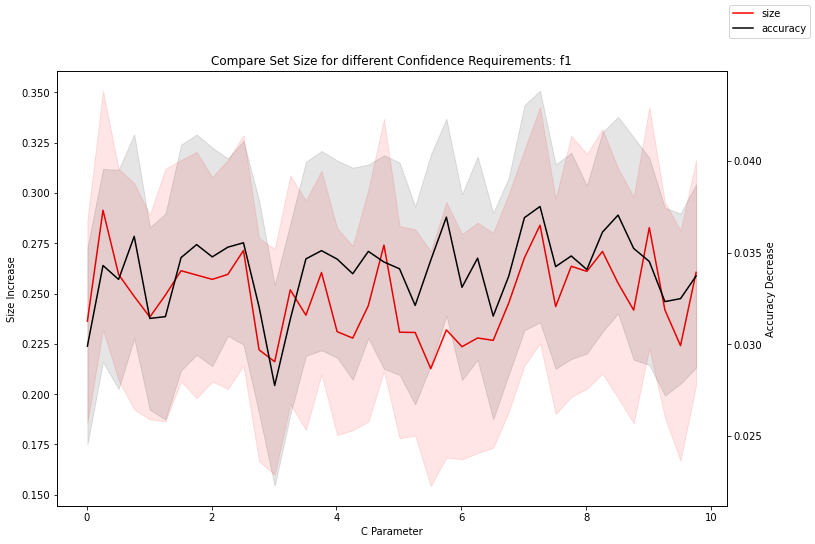

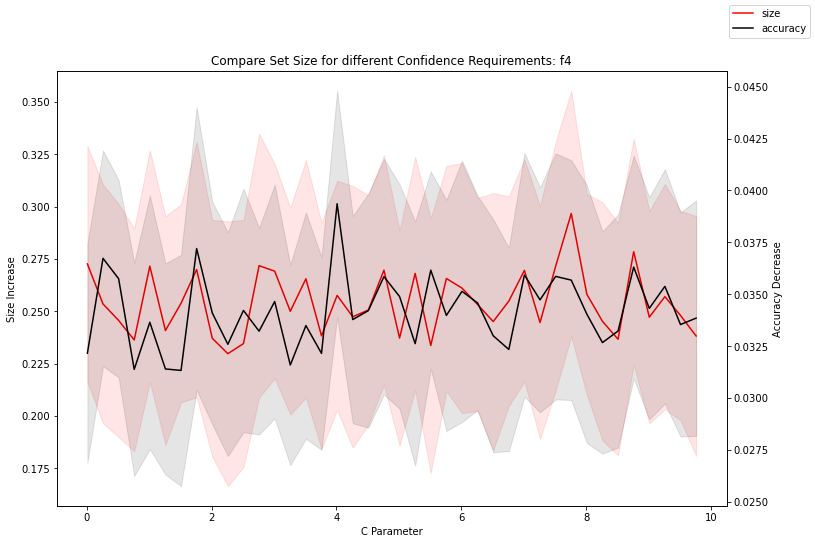

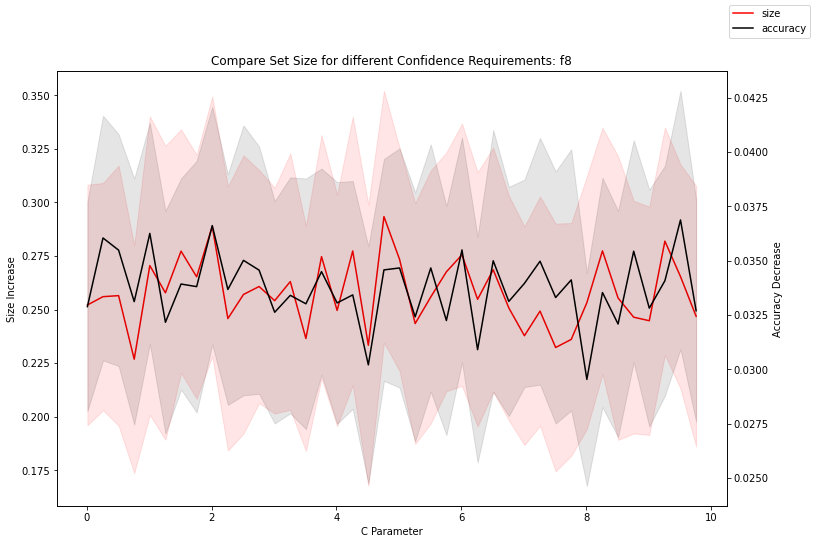

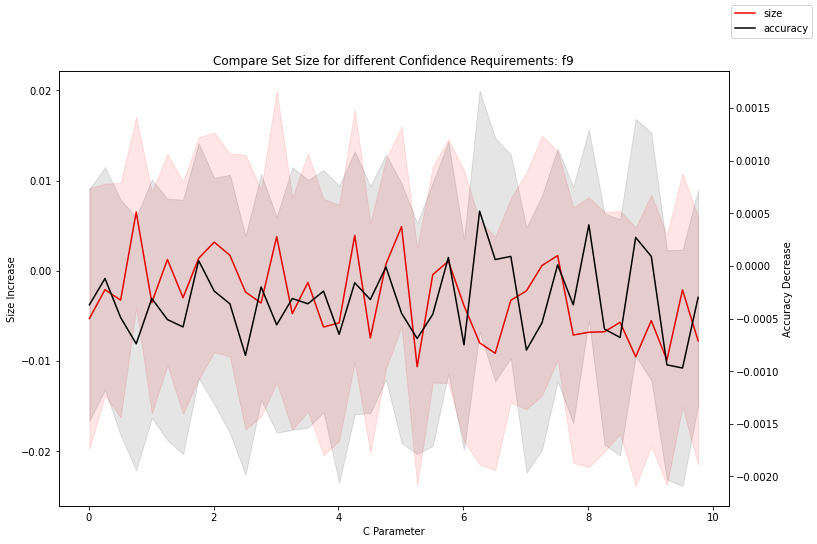

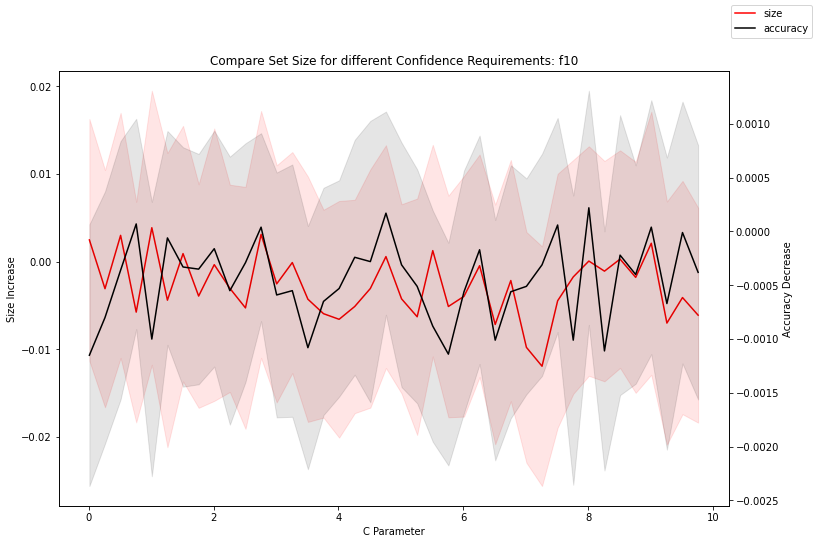

In [50]:
for variable in ['f1', 'f4', 'f8', 'f9', 'f10']:
    fig,ax = plt.subplots(figsize=(12,8))
    ci_size = 1.96*np.std(np.array(ci_dict_size[variable]), axis=1)/np.sqrt(len(ci_dict_size[variable]))
    ci_acc = 1.96*np.std(np.array(ci_dict_acc[variable]), axis=1)/np.sqrt(len(ci_dict_acc[variable]))
    plt.plot(np.arange(min_, max_, steps), average_size[variable], color='red', label='size')
    plt.fill_between(np.arange(min_, max_, steps), (average_size[variable]-ci_size), (average_size[variable]+ci_size), color='red', alpha=.1)
    ax.set_ylabel('Size Increase')
    ax.set_xlabel('C Parameter')
    ax2=ax.twinx()
    ax2.plot(np.arange(min_, max_, steps), accuracy_decrease[variable], color='black', label='accuracy')
    ax2.fill_between(np.arange(min_, max_, steps), (accuracy_decrease[variable]-ci_acc), (accuracy_decrease[variable]+ci_acc), color='black', alpha=.1)
    ax2.set_ylabel('Accuracy Decrease')
    ax.set_title('Compare Set Size for different Confidence Requirements: ' + variable)
    fig.legend()
    plt.savefig('images/Multi_data_correct/logistic_model_performance_' + variable)
    plt.show();

In [37]:
# What is the distribution of conformal for each true class?

alpha = 0.05
B = 1000
class_all = defaultdict(list)
class_vars = defaultdict(lambda: defaultdict(list))

for i in range(B):

    multi_data = MultiClass(n=10000, n_features=10, n_informative=8, n_classes=10)
    multi_data.X_y_split(y='y')

    model = LogisticRegression()
    model.fit(multi_data.train_data_X, multi_data.train_data_y)
    
    simple_conformal = SimpleConformal(alpha=alpha, type='adaptive')
    lambda_all = simple_conformal.calibrate(data_X=multi_data.calib_data_X, data_y=multi_data.calib_data_y, model=model)
    pred_all = simple_conformal.predict(data=multi_data.test_data_X, model=model, lambda_conformal=lambda_all)

    for j, pred in enumerate(pred_all):
        class_all[multi_data.test_data_y.iloc[j]].extend([pred])

    for variable in multi_data.train_data_X.columns:

        data_X_j = copy.copy(multi_data.calib_data_X)
        data_X_j[variable] = 0
        data_X_test_j = copy.copy(multi_data.test_data_X)
        data_X_test_j[variable] = 0

        lambda_j = simple_conformal.calibrate(data_X=data_X_j, data_y=multi_data.calib_data_y, model=model)
        pred_j = simple_conformal.predict(data=data_X_test_j, model=model, lambda_conformal=lambda_j)

        for j, pred in enumerate(pred_j):
            class_vars[variable][multi_data.test_data_y.iloc[j]].extend([pred])


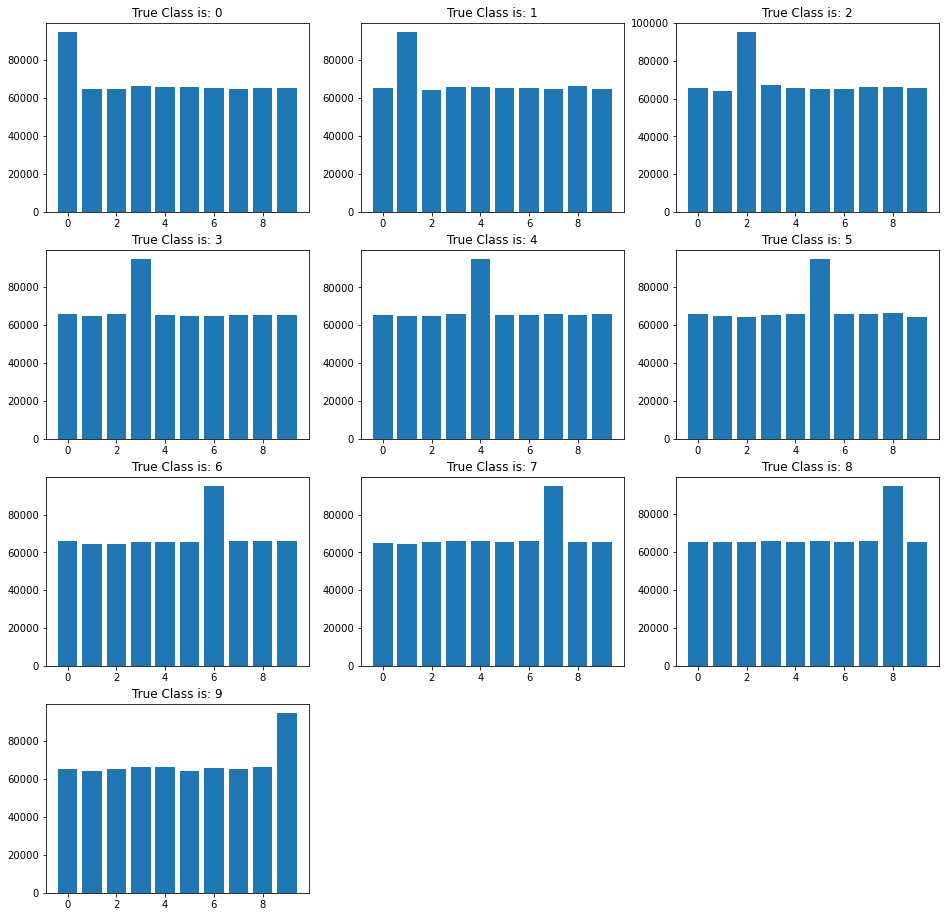

In [38]:
from collections import Counter

def flatten(t):
    return [item for sublist in t for item in sublist]

k = 0
plt.figure(figsize=(16, 16))
for i in range(4):
    for j in range(3):
        ax = plt.subplot2grid((4,3), (i,j))
        c = Counter(flatten(class_all[k]))
        ax.bar(c.keys(), c.values())
        ax.set_title('True Class is: ' + str(k))
        k+=1
        if k == 10:
            break
plt.savefig('images/Multi_data_correct/conformal_set_distribution_all')
plt.show()


In [ ]:
for variable in multi_data.train_data_X.columns:
    k = 0
    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)
    for n, ax in enumerate([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]):

            if n == 9:
                n = 10

            ax = plt.subplot(4, 3, n + 1)

            true = dict(sorted(Counter(np.array(flatten(class_all[k]))).items()))
            x = np.array(flatten(class_vars[variable][k]))

            ax.hist(x, bins=np.arange(11) - 0.5, rwidth=0.85)
            ax.hlines(0, xmin=-1, xmax=10, linestyles='--', colors='r')
            ax.plot(list(true.keys()), list(true.values()), "g-")

            low = 0
            for i, rectangle in enumerate(ax.patches):

                # expected value in the middle of the bar
                exp = list(true.values())[i]

                # difference to the expected value
                diff = exp - rectangle.get_height()
                rectangle.set_y(diff)

                ax.plot(rectangle.get_x() + rectangle.get_width()/2., exp, "go")
                low = min(low, diff)

            ax.set_ylim(bottom=low-10)
            ax.set_xticks(range(10))
            ax.set_title('True Class is: ' + str(k))
            k+=1
            if k == 10:
                break

    plt.suptitle('Remove Variable ' + variable, size=16)
    plt.tight_layout(pad=1.50)
    # plt.savefig('images/Multi_data_correct/conformal_set_distribution_'+ variable)
    plt.show()

In [ ]:
# What is the maximum change we can apply on each variables (independently) such that the conformal prediction remains the same?
dict_store = defaultdict(int)
step = 0.05
max_iter = 300
cols = list(multi_data.train_data_X.columns)

for obs in range(500):
    print((obs/500)*100)
    pred_all = simple_conformal.predict(data=multi_data.test_data_X[obs:obs+1], model=model, lambda_conformal=lambda_all)
    for i, variable in enumerate(multi_data.train_data_X.columns):
        features_up = copy.copy(multi_data.test_data_X.iloc[obs].tolist())
        features_down = copy.copy(multi_data.test_data_X.iloc[obs].tolist())
        step_up = 0
        count = 0
        while True:
            features_up[i] = features_up[i] + step
            data_up = pd.DataFrame([np.array(features_up)], columns=cols)
            pred_up = simple_conformal.predict(data=data_up, model=model, lambda_conformal=lambda_all)
            step_up += step
            count += 1
            if (len(pred_up[0]) > len(pred_all[0])) | (count > max_iter):
                dict_store[variable + 'up'] += step_up
                break
        step_down = 0
        count = 0
        while True:
            features_down[i] = features_down[i] - step
            data_down = pd.DataFrame([np.array(features_down)], columns=cols)
            pred_down = simple_conformal.predict(data=data_down, model=model, lambda_conformal=lambda_all)
            step_down += step
            count += 1
            if (len(pred_down[0]) > len(pred_all[0])) | (count > max_iter):
                dict_store[variable + 'down'] += step_down
                break

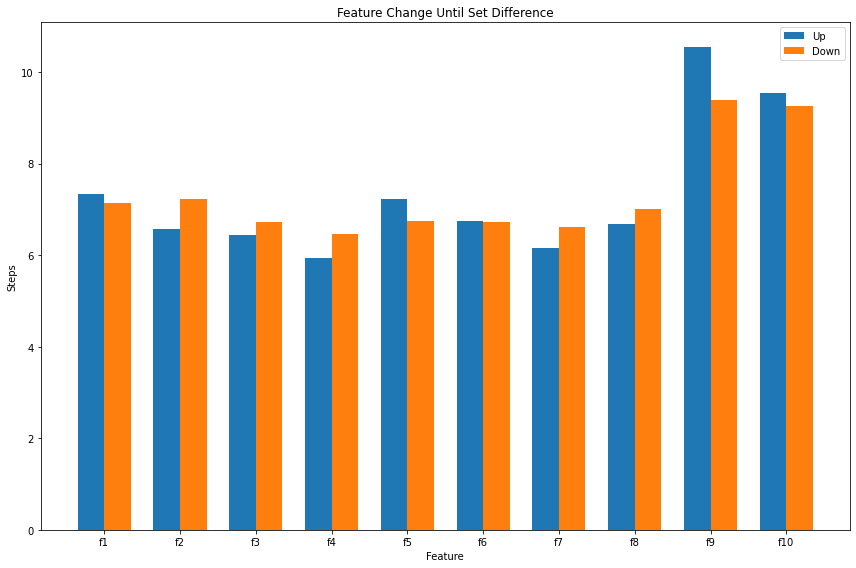

In [68]:
labels = list(multi_data.train_data_X.columns)
l = list(dict_store.values())
up = [l[i]/500 for i in np.arange(0, len(l), 2)]
down = [l[i]/500 for i in np.arange(1, len(l)+1, 2)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width/2, up, width, label='Up')
rects2 = ax.bar(x + width/2, down, width, label='Down')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Feature')
ax.set_ylabel('Steps')
ax.set_title('Feature Change Until Set Difference')
ax.set_xticks(ticks=x)
ax.set_xticklabels( labels=labels)
ax.legend()

fig.tight_layout()
plt.savefig('images/Multi_data_correct/perturbation.png')
plt.show()

### Bootstrap approach

In [17]:
plot = None
B = 1000
model = RandomForestClassifier()
conformal_type = 'adaptive'
alpha = 0.05

multi_data = MultiClass(n=10000, n_features=10, n_informative=8, n_classes=10)
multi_data.X_y_split(y='y')

boot_cov = []
boot_size = []
vars_j_1 = []
vars_j_2 = []
boot_cov_1 = defaultdict(list)
boot_size_1 = defaultdict(list)
boot_cov_2 = defaultdict(list)
boot_size_2 = defaultdict(list)

model_full = model
model_full.fit(multi_data.train_data_X, multi_data.train_data_y)
model_full = copy.copy(model_full)

conformal_predictor = SimpleConformal(alpha=alpha, type=conformal_type)
lambda_all = conformal_predictor.calibrate(data_X=multi_data.calib_data_X, data_y=multi_data.calib_data_y, 
                                                        model=model_full)
pred_all = conformal_predictor.predict(multi_data.test_data_X, model=model_full, lambda_conformal=lambda_all)

cov, size = conformal_predictor.evaluate(pred_all, multi_data.test_data_y, plot=False)

data_X_train = copy.copy(multi_data.train_data_X)
data_X_calib = copy.copy(multi_data.calib_data_X)
data_X_test = copy.copy(multi_data.test_data_X)
    
for variable in multi_data.calib_data_X.columns:

    # Train Twice
    data_X_train_j_2 = data_X_train.loc[:, data_X_train.columns!=variable]
    data_X_calib_j_2 = data_X_calib.loc[:, data_X_calib.columns!=variable]
    data_X_test_j_2 = data_X_test.loc[:, data_X_test.columns!=variable]

    model_j_2 = model
    model_j_2.fit(data_X_train_j_2, multi_data.train_data_y)

    conformal_predictor_j = SimpleConformal(alpha=alpha, type=conformal_type)

    lambda_j_2 = conformal_predictor_j.calibrate(data_X=data_X_calib_j_2, data_y=multi_data.calib_data_y, 
                                                    model=model_j_2)
    pred_j_2 = conformal_predictor_j.predict(data_X_test_j_2, model=model_j_2, lambda_conformal=lambda_j_2)

    cov_j_2, size_j_2 = conformal_predictor_j.evaluate(pred_j_2, multi_data.test_data_y, plot=False)
    vars_j_2.append(size_j_2-size)

    # Train Once
    data_X_calib_j_1 = copy.copy(data_X_calib)
    data_X_calib_j_1[variable] = 0
    data_X_test_j_1 = copy.copy(data_X_test)
    data_X_test_j_1[variable] = 0   

    conformal_predictor_j = SimpleConformal(alpha=alpha, type=conformal_type)

    lambda_j_1 = conformal_predictor_j.calibrate(data_X=data_X_calib_j_1, data_y=multi_data.calib_data_y, 
                                                    model=model_full)
    pred_j_1 = conformal_predictor_j.predict(data_X_test_j_1, model=model_full, lambda_conformal=lambda_j_1)

    cov_j_1, size_j_1 = conformal_predictor_j.evaluate(pred_j_1, multi_data.test_data_y, plot=False)
    vars_j_1.append(size_j_1-size)

for i in range(B):

    if i % 50 == 0:
        print(i)

    train_rand = np.random.choice(np.arange(0, len(multi_data.train_data)), size=len(multi_data.train_data), replace=True)
    calib_rand = np.random.choice(np.arange(0, len(multi_data.calib_data)),size=len(multi_data.calib_data), replace=True)

    train_data_X = copy.copy(multi_data.train_data_X.iloc[train_rand])
    train_data_y = copy.copy(multi_data.train_data_y.iloc[train_rand])
    calib_data_X = copy.copy(multi_data.calib_data_X.iloc[calib_rand])
    calib_data_y = copy.copy(multi_data.calib_data_y.iloc[calib_rand])

    model_full = model
    model_full.fit(train_data_X, train_data_y)
    model_full = copy.copy(model_full)

    conformal_predictor = SimpleConformal(alpha=alpha, type=conformal_type)
    lambda_all = conformal_predictor.calibrate(data_X=calib_data_X, data_y=calib_data_y, 
                                                          model=model_full)
    pred_all = conformal_predictor.predict(multi_data.test_data_X, model=model_full, lambda_conformal=lambda_all)

    cov, size = conformal_predictor.evaluate(pred_all, multi_data.test_data_y, plot=False)

    boot_cov.append(cov)
    boot_size.append(size)

    data_X_train = copy.copy(train_data_X)
    data_X_calib = copy.copy(calib_data_X)
    data_X_test = copy.copy(multi_data.test_data_X)
    
    for variable in multi_data.calib_data_X.columns:

        # Train Twice
        data_X_train_j_2 = data_X_train.loc[:, data_X_train.columns!=variable]
        data_X_calib_j_2 = data_X_calib.loc[:, data_X_calib.columns!=variable]
        data_X_test_j_2 = data_X_test.loc[:, data_X_test.columns!=variable]

        model_j_2 = model
        model_j_2.fit(data_X_train_j_2, train_data_y)

        conformal_predictor_j = SimpleConformal(alpha=alpha, type=conformal_type)

        lambda_j_2 = conformal_predictor_j.calibrate(data_X=data_X_calib_j_2, data_y=calib_data_y, 
                                                     model=model_j_2)
        pred_j_2 = conformal_predictor_j.predict(data_X_test_j_2, model=model_j_2, lambda_conformal=lambda_j_2)

        cov_j_2, size_j_2 = conformal_predictor_j.evaluate(pred_j_2, multi_data.test_data_y, plot=False)

        boot_cov_2[variable].extend([cov_j_2])
        boot_size_2[variable].extend([size_j_2])

        # Train Once
        data_X_calib_j_1 = copy.copy(data_X_calib)
        data_X_calib_j_1[variable] = 0
        data_X_test_j_1 = copy.copy(data_X_test)
        data_X_test_j_1[variable] = 0   

        conformal_predictor_j = SimpleConformal(alpha=alpha, type=conformal_type)

        lambda_j_1 = conformal_predictor_j.calibrate(data_X=data_X_calib_j_1, data_y=calib_data_y, 
                                                     model=model_full)
        pred_j_1 = conformal_predictor_j.predict(data_X_test_j_1, model=model_full, lambda_conformal=lambda_j_1)

        cov_j_1, size_j_1 = conformal_predictor_j.evaluate(pred_j_1, multi_data.test_data_y, plot=False)

        boot_cov_1[variable].extend([cov_j_1])
        boot_size_1[variable].extend([size_j_1])

with open('data_results/Classification/boot_linear_split_size_full.json', 'w') as fp:
    json.dump(boot_size, fp)

with open('data_results/Classification/boot_linear_split_train_once_size.json', 'w') as fp:
    json.dump(boot_size_1, fp)

with open('data_results/Classification/boot_linear_split_train_twice_size.json', 'w') as fp:
    json.dump(boot_size_2, fp)

with open('data_results/Classification/boot_linear_split_train_twice_var_1_j.json', 'w') as fp:
    json.dump(vars_j_1, fp)

with open('data_results/Classification/boot_linear_split_train_twice_var_2_j.json', 'w') as fp:
    json.dump(vars_j_2, fp)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [ ]:
# f = open('data_results/Linear_Regression/linear_split_size_full.json')
# boot_size = json.load(f)

# f = open('data_results/Linear_Regression/linear_split_train_once_size.json')
# boot_size_1 = json.load(f)

# f = open('data_results/Linear_Regression/linear_split_train_twice_size.json')
# boot_size_1 = json.load(f)

f = open('data_results/Classification/rf_adaptive_size_full.json')
sim_size = json.load(f)

f = open('data_results/Classification/rf_adaptive_train_once_size.json')
sim_size_1 = json.load(f)

f = open('data_results/Classification/rf_adaptive_train_twice_size.json')
sim_size_2 = json.load(f)

for i, variable in enumerate(multi_data.calib_data_X.columns):

    data_1 = np.array(boot_size_1[variable]) - np.array(boot_size)
    data_2 = np.array(boot_size_2[variable]) - np.array(boot_size)

    # fixed bin size
    bins = np.arange(min(min(data_1), min(data_2)), max(max(data_1), max(data_2)), (max(max(data_1), 
                     max(data_2))-min(min(data_1), min(data_2)))/50) # fixed bin size
    # bins = 50

    # plt.xlim([min(0, min(data))-5, max(data)+5])

    plt.hist(data_1, bins=bins, alpha=0.7, density=True, label='CP-1')
    plt.hist(data_2, bins=bins, alpha=0.7, density=True, label='CP-2')
    plt.axvline(x=vars_j_1[i], color='black', linestyle='--', label='CP-1 Result')
    plt.axvline(x=vars_j_2[i], color='red', linestyle='--', label='CP-2 Result')
    plt.axvline(x=np.array(sim_size_1[variable]).mean() - np.array(sim_size).mean(), 
                color='purple', linestyle='--', label='Simulated CP-1 Value')
    plt.axvline(x=np.array(sim_size_2[variable]).mean() - np.array(sim_size).mean(), 
                color='green', linestyle='--', label='Simulated CP-2 Value')
    plt.title('Conformal Set Size increase removing ' + variable + '\n Bootstrap')
    plt.xlabel('Size Increase')
    plt.ylabel('Density')
    plt.legend()
    plt.savefig('images/Multi_data_correct/boot_rf_adaptive_'+variable)
    plt.show()

In [12]:
steps = 0.01
B = 100
model = RandomForestClassifier()
conformal_type = 'adaptive'

multi_data = MultiClass(n=10000, n_features=10, n_informative=8, n_classes=10)
multi_data.X_y_split(y='y')

vars_j_1 = defaultdict(list)
vars_j_2 = defaultdict(list)
boot_cov = defaultdict(list)
boot_size = defaultdict(list)
alpha_cov_1 = {}
alpha_cov_2 = {}
alpha_size_1 = {}
alpha_size_2 = {}

for alpha in np.arange(0.01, 1, steps):

    model_full = model
    model_full.fit(multi_data.train_data_X, multi_data.train_data_y)
    model_full = copy.copy(model_full)

    conformal_predictor = SimpleConformal(alpha=alpha, type=conformal_type)
    lambda_all = conformal_predictor.calibrate(data_X=multi_data.calib_data_X, data_y=multi_data.calib_data_y, 
                                                            model=model_full)
    pred_all = conformal_predictor.predict(multi_data.test_data_X, model=model_full, lambda_conformal=lambda_all)

    cov, size = conformal_predictor.evaluate(pred_all, multi_data.test_data_y, plot=False)

    data_X_train = copy.copy(multi_data.train_data_X)
    data_X_calib = copy.copy(multi_data.calib_data_X)
    data_X_test = copy.copy(multi_data.test_data_X)

    for variable in ['f1', 'f4', 'f8', 'f9', 'f10']:

        # Train Twice
        data_X_train_j_2 = data_X_train.loc[:, data_X_train.columns!=variable]
        data_X_calib_j_2 = data_X_calib.loc[:, data_X_calib.columns!=variable]
        data_X_test_j_2 = data_X_test.loc[:, data_X_test.columns!=variable]

        model_j_2 = model
        model_j_2.fit(data_X_train_j_2, multi_data.train_data_y)

        conformal_predictor_j = SimpleConformal(alpha=alpha, type=conformal_type)

        lambda_j_2 = conformal_predictor_j.calibrate(data_X=data_X_calib_j_2, data_y=multi_data.calib_data_y, 
                                                        model=model_j_2)
        pred_j_2 = conformal_predictor_j.predict(data_X_test_j_2, model=model_j_2, lambda_conformal=lambda_j_2)

        cov_j_2, size_j_2 = conformal_predictor_j.evaluate(pred_j_2, multi_data.test_data_y, plot=False)
        vars_j_2[variable].extend([size_j_2-size])

        # Train Once
        data_X_calib_j_1 = copy.copy(data_X_calib)
        data_X_calib_j_1[variable] = 0
        data_X_test_j_1 = copy.copy(data_X_test)
        data_X_test_j_1[variable] = 0   

        conformal_predictor_j = SimpleConformal(alpha=alpha, type=conformal_type)

        lambda_j_1 = conformal_predictor_j.calibrate(data_X=data_X_calib_j_1, data_y=multi_data.calib_data_y, 
                                                        model=model_full)
        pred_j_1 = conformal_predictor_j.predict(data_X_test_j_1, model=model_full, lambda_conformal=lambda_j_1)

        cov_j_1, size_j_1 = conformal_predictor_j.evaluate(pred_j_1, multi_data.test_data_y, plot=False)
        vars_j_1[variable].extend([size_j_1-size])


for alpha in np.arange(0.01, 1, steps):

    boot_cov_1 = defaultdict(list)
    boot_size_1 = defaultdict(list)
    boot_cov_2 = defaultdict(list)
    boot_size_2 = defaultdict(list)

    print(round(alpha, 2))

    for i in range(B):

        train_rand = np.random.choice(np.arange(0, len(multi_data.train_data)), size=len(multi_data.train_data), replace=True)
        calib_rand = np.random.choice(np.arange(0, len(multi_data.calib_data)),size=len(multi_data.calib_data), replace=True)

        train_data_X = copy.copy(multi_data.train_data_X.iloc[train_rand])
        train_data_y = copy.copy(multi_data.train_data_y.iloc[train_rand])
        calib_data_X = copy.copy(multi_data.calib_data_X.iloc[calib_rand])
        calib_data_y = copy.copy(multi_data.calib_data_y.iloc[calib_rand])


        model_full = model
        model_full.fit(train_data_X, train_data_y)
        model_full = copy.copy(model_full)

        conformal_predictor = SimpleConformal(alpha=alpha, type=conformal_type)
        lambda_all = conformal_predictor.calibrate(data_X=calib_data_X, data_y=calib_data_y, 
                                                                model=model_full)
        pred_all = conformal_predictor.predict(multi_data.test_data_X, model=model_full, lambda_conformal=lambda_all)

        cov, size = conformal_predictor.evaluate(pred_all, multi_data.test_data_y, plot=False)

        boot_cov[alpha].extend([cov])
        boot_size[alpha].extend([size])

        data_X_train = copy.copy(train_data_X)
        data_X_calib = copy.copy(calib_data_X)
        data_X_test = copy.copy(multi_data.test_data_X)
        
        for variable in ['f1', 'f4', 'f8', 'f9', 'f10']:

            # Train Twice
            data_X_train_j_2 = data_X_train.loc[:, data_X_train.columns!=variable]
            data_X_calib_j_2 = data_X_calib.loc[:, data_X_calib.columns!=variable]
            data_X_test_j_2 = data_X_test.loc[:, data_X_test.columns!=variable]

            model_j_2 = model
            model_j_2.fit(data_X_train_j_2, train_data_y)

            conformal_predictor_j = SimpleConformal(alpha=alpha, type=conformal_type)

            lambda_j_2 = conformal_predictor_j.calibrate(data_X=data_X_calib_j_2, data_y=calib_data_y, 
                                                        model=model_j_2)
            pred_j_2 = conformal_predictor_j.predict(data_X_test_j_2, model=model_j_2, lambda_conformal=lambda_j_2)

            cov_j_2, size_j_2 = conformal_predictor_j.evaluate(pred_j_2, multi_data.test_data_y, plot=False)
            

            boot_cov_2[variable].extend([cov_j_2])
            boot_size_2[variable].extend([size_j_2])

            # Train Once
            data_X_calib_j_1 = copy.copy(multi_data.calib_data_X)
            data_X_calib_j_1[variable] = 0
            data_X_test_j_1 = copy.copy(multi_data.test_data_X)
            data_X_test_j_1[variable] = 0   

            conformal_predictor_j = SimpleConformal(alpha=alpha, type=conformal_type)

            lambda_j_1 = conformal_predictor_j.calibrate(data_X=data_X_calib_j_1, data_y=calib_data_y, 
                                                        model=model_full)
            pred_j_1 = conformal_predictor_j.predict(data_X_test_j_1, model=model_full, lambda_conformal=lambda_j_1)

            cov_j_1, size_j_1 = conformal_predictor_j.evaluate(pred_j_1, multi_data.test_data_y, plot=False)


            boot_cov_1[variable].extend([cov_j_1])
            boot_size_1[variable].extend([size_j_1])
    
    alpha_cov_1[alpha] = boot_cov_1
    alpha_cov_2[alpha] = boot_cov_2
    alpha_size_1[alpha] = boot_size_1
    alpha_size_2[alpha] = boot_size_2
    
with open('data_results/Classification/bootstrap_alpha_grid_full_size.json', 'w') as fp:
    json.dump(boot_cov, fp)

with open('data_results/Classification/bootstrap_alpha_grid_full_coverage.json', 'w') as fp:
    json.dump(boot_size, fp)

with open('data_results/Classification/bootstrap_alpha_grid_train_once_coverage.json', 'w') as fp:
    json.dump(alpha_cov_1, fp)

with open('data_results/Classification/bootstrap_alpha_grid_train_once_size.json', 'w') as fp:
    json.dump(alpha_size_1, fp)

with open('data_results/Classification/bootstrap_alpha_grid_train_twice_coverage.json', 'w') as fp:
    json.dump(alpha_cov_2, fp)

with open('data_results/Classification/bootstrap_alpha_grid_train_twice_size.json', 'w') as fp:
    json.dump(alpha_size_2, fp)

0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.69
0.7
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.82
0.83
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99


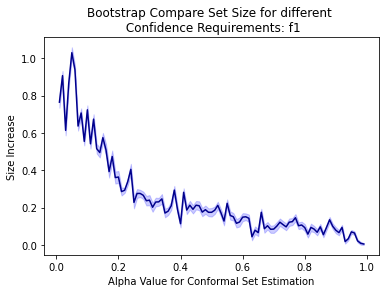

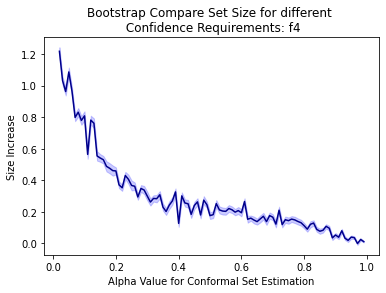

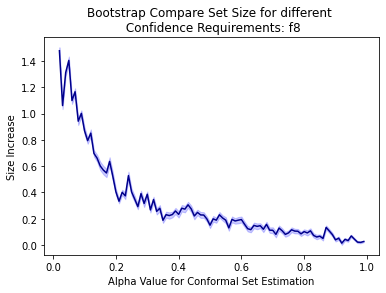

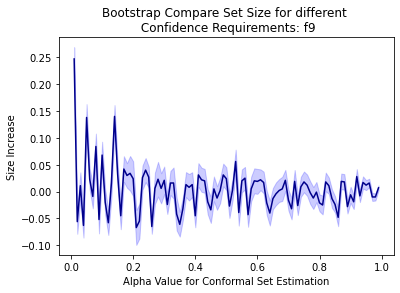

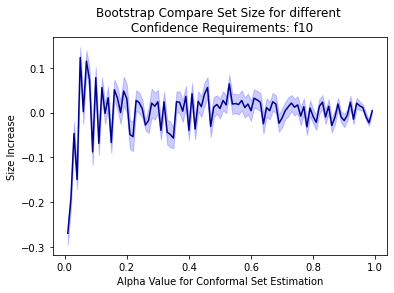

In [23]:
for variable in ['f1', 'f4', 'f8', 'f9', 'f10']:
    data_1 = []
    ci_1 = []
    for alpha in np.arange(0.01, 1, steps):

        data_1.append(np.array(alpha_size_1[alpha][variable]).mean() - np.array(boot_size[alpha]).mean())

        ci_1.append(min(0.03230, 1.96*np.std(np.array(alpha_size_1[alpha][variable]))/np.sqrt(len(alpha_size_1[alpha][variable]))))

    if variable == 'f4' or variable == 'f8':
        plt.plot(np.arange(0.01, 1, steps)[1:], vars_j_1[variable][1:], 'darkblue', label='CP-1')
        plt.fill_between(np.arange(0.01, 1, steps)[1:], (np.array(vars_j_1[variable][1:])-np.array(ci_1[1:])), 
                    (np.array(vars_j_1[variable][1:])+np.array(ci_1)[1:]), color='blue', alpha=.2)
    else:
        plt.plot(np.arange(0.01, 1, steps), vars_j_1[variable], 'darkblue', label='CP-1')
        plt.fill_between(np.arange(0.01, 1, steps), (np.array(vars_j_1[variable])-np.array(ci_1)), 
                        (np.array(vars_j_1[variable])+np.array(ci_1)), color='blue', alpha=.2)
    plt.ylabel('Size Increase')
    plt.xlabel('Alpha Value for Conformal Set Estimation')
    plt.title('Bootstrap Compare Set Size for different \n Confidence Requirements: ' + variable)
    plt.savefig('images/Multi_data_correct/bootstrap_alpha_grid_' + variable)
    plt.show()

In [16]:
ci_1.sort()

In [18]:
ci_1[::-1]

[0.514999420591362,
 0.3540714621082586,
 0.33612036214064744,
 0.10709977872693485,
 0.10616752643175972,
 0.03230305154288678,
 0.03016609225142693,
 0.02985863022187053,
 0.02923408503924143,
 0.0272495169824054,
 0.027181354340827097,
 0.026640466797712085,
 0.026502770090871635,
 0.025983959657942823,
 0.025801073725750256,
 0.02574958636293795,
 0.025651423602942584,
 0.025546255034693443,
 0.025314860662464644,
 0.02483770898291547,
 0.024837617651264382,
 0.024545437392590908,
 0.024333595683466096,
 0.02415832513038932,
 0.024142750135442318,
 0.023841760568380842,
 0.02366721637002544,
 0.02359228307931218,
 0.023465194244787317,
 0.023342033181674653,
 0.02326080659275598,
 0.023085715955317485,
 0.022982743957708798,
 0.022944947338148326,
 0.02267762350512064,
 0.022621061214328563,
 0.022558264146374383,
 0.022374085603161536,
 0.022293358794977493,
 0.022222946052618684,
 0.022205727336847128,
 0.022039059527629575,
 0.02200561088609903,
 0.02194756470193447,
 0.02192479